In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dhoot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import LinearSVC

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

import seaborn as sns
import matplotlib.pyplot as plt



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dhoot\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [18]:
data = pd.read_csv('airline_new_change.csv')
    #'Airline_review_cleaned.csv')

In [19]:
data.head(1)

Sr No     Airline Name Overall_Rating             Review_Title  \
0      0  Delta Air Lines              9  "pretty decent airline"   

          Review Date  Verified  \
0  11th November 2019      True   

                                              Review Aircraft  \
0    Moroni to Moheli. Turned out to be a pretty ...      NaN   

  Type Of Traveller      Seat Type             Route  Date Flown  \
0      Solo Leisure  Economy Class  Moroni to Moheli  11-01-2019   

   Seat Comfort  Cabin Staff Service  Food & Beverages  Ground Service  \
0           4.0                  5.0               4.0             4.0   

   Inflight Entertainment  Wifi & Connectivity  Value For Money Recommended  \
0                     NaN                  NaN              3.0         yes   

  Airline_dupe  
0  AB Aviation

<AxesSubplot:>

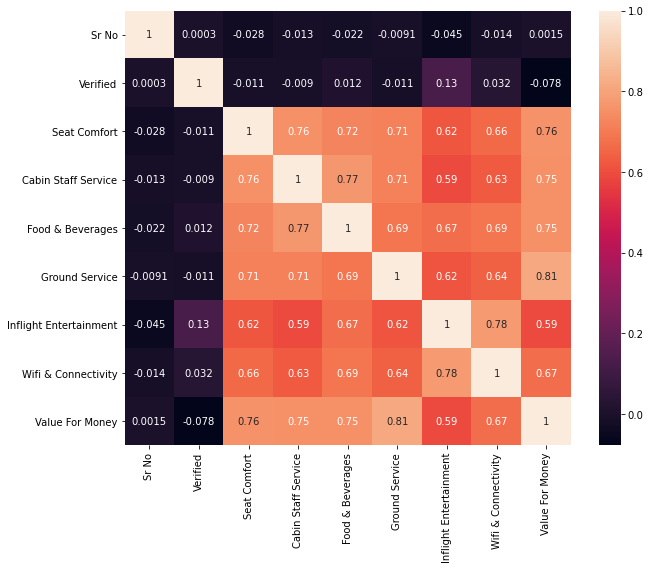

In [20]:
# plotting correlation heatmap
plt.figure(figsize=(10, 8))

sns.heatmap(data.corr(), annot = True)

# looking at heatmap above we select following columns to avoid correlation problems between predictor variables
ASK divya to work on filling routes columns to avoid NAn

In [21]:
pd.set_option('display.max_columns', 500)
data.head(1)
data[data['Seat Comfort'].isnull()]


df1a = data[['Review','Review_Title','Airline Name', 'Overall_Rating',  'Review Date','Verified','Route', 'Date Flown', 'Seat Comfort',
       'Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Recommended']]
df1a = df1a.rename(columns={'Review_Title':'Overall_review','Airline Name':'airline_name','Review Date':'review_date','Date Flown':"date_flown", 'Seat Comfort':"seat_comfort",
       'Cabin Staff Service':"cabin_staff_service", 'Food & Beverages':"food", 'Inflight Entertainment':"entertainment"})
df1a.head(1)

Review           Overall_review  \
0    Moroni to Moheli. Turned out to be a pretty ...  "pretty decent airline"   

      airline_name Overall_Rating         review_date  Verified  \
0  Delta Air Lines              9  11th November 2019      True   

              Route  date_flown  seat_comfort  cabin_staff_service  food  \
0  Moroni to Moheli  11-01-2019           4.0                  5.0   4.0   

   entertainment Recommended  
0            NaN         yes

In [22]:
#checking for null values
df1a.isnull().sum()

Review                     0
Overall_review             0
airline_name               0
Overall_Rating             0
review_date                0
Verified                   0
Route                      0
date_flown                 0
seat_comfort            4155
cabin_staff_service     4260
food                    8671
entertainment          12342
Recommended                0
dtype: int64

In [23]:
df1a['seat_comfort'] = df1a.groupby(['airline_name'])['seat_comfort'].apply(lambda x: x.fillna(x.mean()))
df1a['cabin_staff_service'] = df1a.groupby(['airline_name'])['cabin_staff_service'].apply(lambda x: x.fillna(x.mean()))
df1a['food'] = df1a.groupby(['airline_name'])['food'].apply(lambda x: x.fillna(x.mean()))
df1a['entertainment'] = df1a.groupby(['airline_name'])['entertainment'].apply(lambda x: x.fillna(x.mean()))

In [24]:
df1a['seat_comfort'] = df1a['seat_comfort'].astype('int')
df1a['cabin_staff_service'] = df1a['cabin_staff_service'].astype('int')
df1a['food'] = df1a['food'].astype('int')
df1a['entertainment'] = df1a['entertainment'].astype('int')

In [25]:
df1a['Review'] = df1a['Review'].str.replace(r'\.{2,}', '.')

<ipython-input-25-8525bd444be5>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df1a['Review'] = df1a['Review'].str.replace(r'\.{2,}', '.')


In [26]:
df1a.columns

Index(['Review', 'Overall_review', 'airline_name', 'Overall_Rating',
       'review_date', 'Verified', 'Route', 'date_flown', 'seat_comfort',
       'cabin_staff_service', 'food', 'entertainment', 'Recommended'],
      dtype='object')

In [27]:
#cleaning text by removing unwanted spaces, characters 
features = df1a.iloc[:, 0].values
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'[^.\w\s]', ' ', str(features[sentence]))
    
    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [28]:
df2 = pd.DataFrame(processed_features,columns={'review_new'})
df2.head()

review_new
0   moroni to moheli. turned out to be pretty dec...
1   moroni to anjouan. it is very small airline. ...
2   anjouan to dzaoudzi. very small airline and t...
3   please do favor yourself and do not fly with ...
4   do not book flight with this airline my frien...

In [29]:
#concating processed reviews to original df1a
df1a = pd.concat([df1a, df2], axis=1)
df1a = df1a.drop('Review',axis=1)
df1a = df1a[['airline_name','Overall_Rating','review_date','Verified','Overall_review','review_new', 'Route', 'date_flown', 'seat_comfort',
       'cabin_staff_service', 'food', 'entertainment', 'Recommended']]
df1a.head()

airline_name Overall_Rating          review_date  Verified  \
0  Delta Air Lines              9   11th November 2019      True   
1  Delta Air Lines              1       25th June 2019      True   
2  Delta Air Lines              1       25th June 2019      True   
3  Delta Air Lines              1  28th September 2019     False   
4  Delta Air Lines              1  24th September 2019      True   

                          Overall_review  \
0                "pretty decent airline"   
1                   "Not a good airline"   
2         "flight was fortunately short"   
3    "I will never fly again with Adria"   
4  "it ruined our last days of holidays"   

                                          review_new  \
0   moroni to moheli. turned out to be pretty dec...   
1   moroni to anjouan. it is very small airline. ...   
2   anjouan to dzaoudzi. very small airline and t...   
3   please do favor yourself and do not fly with ...   
4   do not book flight with this airline my frien...   

                              Route  date_flown  seat_comfort  \
0                  Moroni to Moheli  11-01-2019             4   
1                 Moroni to Anjouan  06-01-2019             2   
2               Anjouan to Dzaoudzi  06-01-2019             2   
3             Frankfurt to Pristina  09-01-2019             1   
4  Sofia to Amsterdam via Ljubljana  09-01-2019             1   

   cabin_staff_service  food  entertainment Recommended  
0                    5     4              2         yes  
1                    2     1              2          no  
2                    1     1              2          no  
3                    1     2              2          no  
4                    1     1              1          no

In [30]:
# Splitting data based on delimiters to do sentiment analysis at granular level
df1a = pd.concat([df1a,df1a.review_new.str.split('.',expand=True)],axis=1)
df1a = pd.concat([df1a,df1a.review_new.str.split('but',expand=True)],axis=1) 

In [31]:
df1a.head()

airline_name Overall_Rating          review_date  Verified  \
0  Delta Air Lines              9   11th November 2019      True   
1  Delta Air Lines              1       25th June 2019      True   
2  Delta Air Lines              1       25th June 2019      True   
3  Delta Air Lines              1  28th September 2019     False   
4  Delta Air Lines              1  24th September 2019      True   

                          Overall_review  \
0                "pretty decent airline"   
1                   "Not a good airline"   
2         "flight was fortunately short"   
3    "I will never fly again with Adria"   
4  "it ruined our last days of holidays"   

                                          review_new  \
0   moroni to moheli. turned out to be pretty dec...   
1   moroni to anjouan. it is very small airline. ...   
2   anjouan to dzaoudzi. very small airline and t...   
3   please do favor yourself and do not fly with ...   
4   do not book flight with this airline my frien...   

                              Route  date_flown  seat_comfort  \
0                  Moroni to Moheli  11-01-2019             4   
1                 Moroni to Anjouan  06-01-2019             2   
2               Anjouan to Dzaoudzi  06-01-2019             2   
3             Frankfurt to Pristina  09-01-2019             1   
4  Sofia to Amsterdam via Ljubljana  09-01-2019             1   

   cabin_staff_service  food  entertainment Recommended  \
0                    5     4              2         yes   
1                    2     1              2          no   
2                    1     1              2          no   
3                    1     2              2          no   
4                    1     1              1          no   

                                                   0  \
0                                   moroni to moheli   
1                                  moroni to anjouan   
2                                anjouan to dzaoudzi   
3   please do favor yourself and do not fly with ...   
4   do not book flight with this airline my frien...   

                                                   1  \
0             turned out to be pretty decent airline   
1                           it is very small airline   
2   very small airline and the only airline based...   
3   on the route from munich to pristina in july ...   
4   for 3 straight days we tried to reach the air...   

                                                   2  \
0   online booking worked well checkin and boardi...   
1   my ticket advised me to turn up at 0800hrs wh...   
2   check in was disorganised because of locals w...   
3   11 days later the luggage arrived at the dest...   
4   finally 18 hours before our cancelled flight ...   

                                                   3  \
0   its very short flight just 20 minutes or so s...   
1          there was confusion at this small airport   
2          the flight was fortunately short 30 mins    
3   applying for compensation they ignored my req...   
4   do not book delta air lines it is unreliable ...   

                                                   4  \
0                               both flights on time   
1   was then directed to the office of delta air ...   
2                took off on time and landed on time   
3   foolishly again booked another flight with th...   
4                                                      

                                                   5  \
0                                                      
1   it opened at 0900hrs and was told that the fl...   
2   with short flight like there was of course no...   
3   they cancelled the flight with no reason 24 h...   
4                                               None   

                                                   6  \
0                                               None   
1   this could not be true as they did not have m...   
2                                               None   
3  

In [32]:
# selecting only columns that is required
df3 = df1a.iloc[:,0:25]
df3.isnull().sum()

airline_name               0
Overall_Rating             0
review_date                0
Verified                   0
Overall_review             0
review_new                 0
Route                      0
date_flown                 0
seat_comfort               0
cabin_staff_service        0
food                       0
entertainment              0
Recommended                0
0                          0
1                         35
2                        213
3                        903
4                       2627
5                       5269
6                       8179
7                      10956
8                      13309
9                      15226
10                     16759
11                     18017
dtype: int64

In [33]:
#dynamically renaming columns
l = []
for i in range(len(df3.columns)):
    #print(i)
    if i == 0:
        l1 = 'airline_name'
        l.append(l1)
    elif i == 1:
        l1 = 'Overall_Rating'
        l.append(l1)
    elif i==2:
        l1 = 'review_date'
        l.append(l1)
    elif i==3:
        l1 = 'Verified'
        l.append(l1)
    elif i==4:
        l1 = 'Overall_review'
        l.append(l1)
    elif i==5:
        l1 = 'review_new'
        l.append(l1)
    elif i==6:
        l1 = 'Route'
        l.append(l1)
    elif i==7:
        l1 = 'date_flown'
        l.append(l1)
    elif i==8:
        l1 = 'seat_comfort'
        l.append(l1)
    elif i==9:
        l1 = 'cabin_staff_service'
        l.append(l1)
    elif i==10:
        l1 = 'food'
        l.append(l1)
    elif i==11:
        l1 = 'entertainment'
        l.append(l1)
    elif i==12:
        l1 = 'Recommended'
        l.append(l1)
    else:
        l1 = 'r'+''+str(i)
        l.append(l1)
df3.columns = l
print(df3.columns)

Index(['airline_name', 'Overall_Rating', 'review_date', 'Verified',
       'Overall_review', 'review_new', 'Route', 'date_flown', 'seat_comfort',
       'cabin_staff_service', 'food', 'entertainment', 'Recommended', 'r13',
       'r14', 'r15', 'r16', 'r17', 'r18', 'r19', 'r20', 'r21', 'r22', 'r23',
       'r24'],
      dtype='object')


In [34]:
#replacing NaN values with space
for i in df3.columns:
    
    df3.loc[df3[i].isnull(),i]=' '

df3.head()

airline_name Overall_Rating          review_date Verified  \
0  Delta Air Lines              9   11th November 2019     True   
1  Delta Air Lines              1       25th June 2019     True   
2  Delta Air Lines              1       25th June 2019     True   
3  Delta Air Lines              1  28th September 2019    False   
4  Delta Air Lines              1  24th September 2019     True   

                          Overall_review  \
0                "pretty decent airline"   
1                   "Not a good airline"   
2         "flight was fortunately short"   
3    "I will never fly again with Adria"   
4  "it ruined our last days of holidays"   

                                          review_new  \
0   moroni to moheli. turned out to be pretty dec...   
1   moroni to anjouan. it is very small airline. ...   
2   anjouan to dzaoudzi. very small airline and t...   
3   please do favor yourself and do not fly with ...   
4   do not book flight with this airline my frien...   

                              Route  date_flown seat_comfort  \
0                  Moroni to Moheli  11-01-2019            4   
1                 Moroni to Anjouan  06-01-2019            2   
2               Anjouan to Dzaoudzi  06-01-2019            2   
3             Frankfurt to Pristina  09-01-2019            1   
4  Sofia to Amsterdam via Ljubljana  09-01-2019            1   

  cabin_staff_service food entertainment Recommended  \
0                   5    4             2         yes   
1                   2    1             2          no   
2                   1    1             2          no   
3                   1    2             2          no   
4                   1    1             1          no   

                                                 r13  \
0                                   moroni to moheli   
1                                  moroni to anjouan   
2                                anjouan to dzaoudzi   
3   please do favor yourself and do not fly with ...   
4   do not book flight with this airline my frien...   

                                                 r14  \
0             turned out to be pretty decent airline   
1                           it is very small airline   
2   very small airline and the only airline based...   
3   on the route from munich to pristina in july ...   
4   for 3 straight days we tried to reach the air...   

                                                 r15  \
0   online booking worked well checkin and boardi...   
1   my ticket advised me to turn up at 0800hrs wh...   
2   check in was disorganised because of locals w...   
3   11 days later the luggage arrived at the dest...   
4   finally 18 hours before our cancelled flight ...   

                                                 r16  \
0   its very short flight just 20 minutes or so s...   
1          there was confusion at this small airport   
2          the flight was fortunately short 30 mins    
3   applying for compensation they ignored my req...   
4   do not book delta air lines it is unreliable ...   

                                                 r17  \
0                               both flights on time   
1   was then directed to the office of delta air ...   
2                took off on time and landed on time   
3   foolishly again booked another flight with th...   
4                                                      

                                                 r18  \
0                                                      
1   it opened at 0900hrs and was told that the fl...   
2   with short flight like there was of course no...   
3   they cancelled the flight with no reason 24 h...   
4                                                      

                                                 r19  \
0                                                      
1   this could not be true as they did not have m...   
2                                                      
3   desperate phone calls to cust

In [35]:
df3.columns

Index(['airline_name', 'Overall_Rating', 'review_date', 'Verified',
       'Overall_review', 'review_new', 'Route', 'date_flown', 'seat_comfort',
       'cabin_staff_service', 'food', 'entertainment', 'Recommended', 'r13',
       'r14', 'r15', 'r16', 'r17', 'r18', 'r19', 'r20', 'r21', 'r22', 'r23',
       'r24'],
      dtype='object')

In [36]:
# defining function that performs sentiments analysis by calculating the weights of +ve or -ve words and 
#accordingly generating sentiment scores to buckt it in positive,negative, neutral

analyser = SentimentIntensityAnalyzer()
def calculate_sentiment(Clean_text):
    return TextBlob(Clean_text).sentiment

def calculate_sentiment_analyser(Clean_text):
    return analyser.polarity_scores(Clean_text)

In [37]:
# using abv function to calculate score
non_sentiment_columns = ['airline_name', 'review_date','Overall_Rating','Verified', 'Route', 'date_flown', 'seat_comfort',
       'cabin_staff_service', 'food', 'entertainment', 'Recommended']
for i in df3.columns:
    if i not in non_sentiment_columns:
        df3['sentiment'+'_'+str(i)]=df3[str(i)].apply(calculate_sentiment)
        df3['sentiment_analyser'+'_'+str(i)]=df3[str(i)].apply(calculate_sentiment_analyser)


df3 = df3.reset_index()
df3 = df3.drop(['index'],axis=1)

In [38]:
df3 = df3.rename(columns={"sentiment_analyser_Overall_review":"sentiment_analyser_Overall_review_O1","sentiment_analyser_review_new":"sentiment_analyser_review_new_N1"})

In [39]:
#keeping copy in data to avoid re-running sentiment model and time consumption
df3_copy = df3.copy()

In [40]:
df3 = df3_copy.copy()

In [41]:
df3.head()
df3['sentiment_analyser_Overall_review_O1'][0]
df3.columns

Index(['airline_name', 'Overall_Rating', 'review_date', 'Verified',
       'Overall_review', 'review_new', 'Route', 'date_flown', 'seat_comfort',
       'cabin_staff_service', 'food', 'entertainment', 'Recommended', 'r13',
       'r14', 'r15', 'r16', 'r17', 'r18', 'r19', 'r20', 'r21', 'r22', 'r23',
       'r24', 'sentiment_Overall_review',
       'sentiment_analyser_Overall_review_O1', 'sentiment_review_new',
       'sentiment_analyser_review_new_N1', 'sentiment_r13',
       'sentiment_analyser_r13', 'sentiment_r14', 'sentiment_analyser_r14',
       'sentiment_r15', 'sentiment_analyser_r15', 'sentiment_r16',
       'sentiment_analyser_r16', 'sentiment_r17', 'sentiment_analyser_r17',
       'sentiment_r18', 'sentiment_analyser_r18', 'sentiment_r19',
       'sentiment_analyser_r19', 'sentiment_r20', 'sentiment_analyser_r20',
       'sentiment_r21', 'sentiment_analyser_r21', 'sentiment_r22',
       'sentiment_analyser_r22', 'sentiment_r23', 'sentiment_analyser_r23',
       'sentiment_r24'

In [42]:
# extracting compound score in separate column
for i in range(df3.shape[1]):
        columns_list = df3.columns
        if i>=25:
            #print(i)
            column_name = columns_list[i]
            #print(column_name)
            j = column_name[-2:]
            #print(j)
            if 'analyser' in column_name:
                df3['sentiment_analyser_compound'+str(j)] = [d.get('compound') for d in df3[column_name]]

In [43]:
df3.head()

airline_name Overall_Rating          review_date Verified  \
0  Delta Air Lines              9   11th November 2019     True   
1  Delta Air Lines              1       25th June 2019     True   
2  Delta Air Lines              1       25th June 2019     True   
3  Delta Air Lines              1  28th September 2019    False   
4  Delta Air Lines              1  24th September 2019     True   

                          Overall_review  \
0                "pretty decent airline"   
1                   "Not a good airline"   
2         "flight was fortunately short"   
3    "I will never fly again with Adria"   
4  "it ruined our last days of holidays"   

                                          review_new  \
0   moroni to moheli. turned out to be pretty dec...   
1   moroni to anjouan. it is very small airline. ...   
2   anjouan to dzaoudzi. very small airline and t...   
3   please do favor yourself and do not fly with ...   
4   do not book flight with this airline my frien...   

                              Route  date_flown seat_comfort  \
0                  Moroni to Moheli  11-01-2019            4   
1                 Moroni to Anjouan  06-01-2019            2   
2               Anjouan to Dzaoudzi  06-01-2019            2   
3             Frankfurt to Pristina  09-01-2019            1   
4  Sofia to Amsterdam via Ljubljana  09-01-2019            1   

  cabin_staff_service food entertainment Recommended  \
0                   5    4             2         yes   
1                   2    1             2          no   
2                   1    1             2          no   
3                   1    2             2          no   
4                   1    1             1          no   

                                                 r13  \
0                                   moroni to moheli   
1                                  moroni to anjouan   
2                                anjouan to dzaoudzi   
3   please do favor yourself and do not fly with ...   
4   do not book flight with this airline my frien...   

                                                 r14  \
0             turned out to be pretty decent airline   
1                           it is very small airline   
2   very small airline and the only airline based...   
3   on the route from munich to pristina in july ...   
4   for 3 straight days we tried to reach the air...   

                                                 r15  \
0   online booking worked well checkin and boardi...   
1   my ticket advised me to turn up at 0800hrs wh...   
2   check in was disorganised because of locals w...   
3   11 days later the luggage arrived at the dest...   
4   finally 18 hours before our cancelled flight ...   

                                                 r16  \
0   its very short flight just 20 minutes or so s...   
1          there was confusion at this small airport   
2          the flight was fortunately short 30 mins    
3   applying for compensation they ignored my req...   
4   do not book delta air lines it is unreliable ...   

                                                 r17  \
0                               both flights on time   
1   was then directed to the office of delta air ...   
2                took off on time and landed on time   
3   foolishly again booked another flight with th...   
4                                                      

                                                 r18  \
0                                                      
1   it opened at 0900hrs and was told that the fl...   
2   with short flight like there was of course no...   
3   they cancelled the flight with no reason 24 h...   
4                                                      

                                                 r19  \
0                                                      
1   this could not be true as they did not have m...   
2                                                      
3   desperate phone calls to cust

In [44]:
#EXTRACTING SENTIMENT LABELS
for i in range(df3.shape[1]):
    #print(i)
    columns_list = df3.columns
    #print(len(i))
    if i >=53:
        column_name = columns_list[i]
        #print(column_name)
        j = column_name[-2:]
        df3.loc[df3[column_name]<=-0.05,'compound_score_sentiment'+str(j)] = 'Negative'
        df3.loc[df3[column_name]>=0.05,'compound_score_sentiment'+str(j)] = 'Positive'
        df3.loc[(df3[column_name]>=-0.05) & (df3[column_name]<=0.05),'compound_score_sentiment'+str(j)] = 'Neutral'

In [45]:
rows = df3.shape[0]
df3['level'] = pd.Series(range(0,rows+1))

In [46]:
df3.head()

airline_name Overall_Rating          review_date Verified  \
0  Delta Air Lines              9   11th November 2019     True   
1  Delta Air Lines              1       25th June 2019     True   
2  Delta Air Lines              1       25th June 2019     True   
3  Delta Air Lines              1  28th September 2019    False   
4  Delta Air Lines              1  24th September 2019     True   

                          Overall_review  \
0                "pretty decent airline"   
1                   "Not a good airline"   
2         "flight was fortunately short"   
3    "I will never fly again with Adria"   
4  "it ruined our last days of holidays"   

                                          review_new  \
0   moroni to moheli. turned out to be pretty dec...   
1   moroni to anjouan. it is very small airline. ...   
2   anjouan to dzaoudzi. very small airline and t...   
3   please do favor yourself and do not fly with ...   
4   do not book flight with this airline my frien...   

                              Route  date_flown seat_comfort  \
0                  Moroni to Moheli  11-01-2019            4   
1                 Moroni to Anjouan  06-01-2019            2   
2               Anjouan to Dzaoudzi  06-01-2019            2   
3             Frankfurt to Pristina  09-01-2019            1   
4  Sofia to Amsterdam via Ljubljana  09-01-2019            1   

  cabin_staff_service food entertainment Recommended  \
0                   5    4             2         yes   
1                   2    1             2          no   
2                   1    1             2          no   
3                   1    2             2          no   
4                   1    1             1          no   

                                                 r13  \
0                                   moroni to moheli   
1                                  moroni to anjouan   
2                                anjouan to dzaoudzi   
3   please do favor yourself and do not fly with ...   
4   do not book flight with this airline my frien...   

                                                 r14  \
0             turned out to be pretty decent airline   
1                           it is very small airline   
2   very small airline and the only airline based...   
3   on the route from munich to pristina in july ...   
4   for 3 straight days we tried to reach the air...   

                                                 r15  \
0   online booking worked well checkin and boardi...   
1   my ticket advised me to turn up at 0800hrs wh...   
2   check in was disorganised because of locals w...   
3   11 days later the luggage arrived at the dest...   
4   finally 18 hours before our cancelled flight ...   

                                                 r16  \
0   its very short flight just 20 minutes or so s...   
1          there was confusion at this small airport   
2          the flight was fortunately short 30 mins    
3   applying for compensation they ignored my req...   
4   do not book delta air lines it is unreliable ...   

                                                 r17  \
0                               both flights on time   
1   was then directed to the office of delta air ...   
2                took off on time and landed on time   
3   foolishly again booked another flight with th...   
4                                                      

                                                 r18  \
0                                                      
1   it opened at 0900hrs and was told that the fl...   
2   with short flight like there was of course no...   
3   they cancelled the flight with no reason 24 h...   
4                                                      

                                                 r19  \
0                                                      
1   this could not be true as they did not have m...   
2                                                      
3   desperate phone calls to cust

In [47]:
# converting column to row format
df3.tail(1)
df4_line_reviews_stack = df3.iloc[:,13:25]
df4_line_reviews_stack.head(1)

df4_line_reviews_stack = df4_line_reviews_stack.stack().reset_index()
df4_line_reviews_stack= df4_line_reviews_stack.rename(columns={"level_0":"level","level_1":"review_column_name",0:"line_review"}) 
df4_line_reviews_stack.head(2)

level review_column_name                              line_review
0      0                r13                         moroni to moheli
1      0                r14   turned out to be pretty decent airline

In [48]:
# converting column to row format
df5_sentiment_compound_score = df3.iloc[:,55:67]
df5_sentiment_compound_score.head()

df5_sentiment_compound_score = df5_sentiment_compound_score.stack().reset_index()
df5_sentiment_compound_score= df5_sentiment_compound_score.rename(columns={"level_0":"level","level_1":"sentiment_analyser_columns",0:"sentiment_compund_score"}) 
df5_sentiment_compound_score.head(2)

level     sentiment_analyser_columns  sentiment_compund_score
0      0  sentiment_analyser_compound13                   0.0000
1      0  sentiment_analyser_compound14                   0.4939

In [49]:
# converting column to row format
df6_sentiments = df3.iloc[:,69:81]
df6_sentiments.head()

df6_sentiments = df6_sentiments.stack().reset_index()
df6_sentiments= df6_sentiments.rename(columns={"level_0":"level","level_1":"sentiment_column_name",0:"sentiments"}) 
df6_sentiments.head(2)

level       sentiment_column_name sentiments
0      0  compound_score_sentiment13    Neutral
1      0  compound_score_sentiment14   Positive

In [50]:
df3.columns

Index(['airline_name', 'Overall_Rating', 'review_date', 'Verified',
       'Overall_review', 'review_new', 'Route', 'date_flown', 'seat_comfort',
       'cabin_staff_service', 'food', 'entertainment', 'Recommended', 'r13',
       'r14', 'r15', 'r16', 'r17', 'r18', 'r19', 'r20', 'r21', 'r22', 'r23',
       'r24', 'sentiment_Overall_review',
       'sentiment_analyser_Overall_review_O1', 'sentiment_review_new',
       'sentiment_analyser_review_new_N1', 'sentiment_r13',
       'sentiment_analyser_r13', 'sentiment_r14', 'sentiment_analyser_r14',
       'sentiment_r15', 'sentiment_analyser_r15', 'sentiment_r16',
       'sentiment_analyser_r16', 'sentiment_r17', 'sentiment_analyser_r17',
       'sentiment_r18', 'sentiment_analyser_r18', 'sentiment_r19',
       'sentiment_analyser_r19', 'sentiment_r20', 'sentiment_analyser_r20',
       'sentiment_r21', 'sentiment_analyser_r21', 'sentiment_r22',
       'sentiment_analyser_r22', 'sentiment_r23', 'sentiment_analyser_r23',
       'sentiment_r24'

In [51]:
df_final = pd.merge(df3,df4_line_reviews_stack, on='level', how='inner')
df_final = df_final[['airline_name', 'Overall_Rating', 'review_date','Verified','Overall_review', 'review_new', 'Route', 'date_flown', 'seat_comfort',
       'cabin_staff_service', 'food', 'entertainment', 'Recommended', 'r13','r14', 'r15', 'r16', 'r17', 'r18', 'r19', 'r20', 'r21', 'r22', 'r23',
       'r24', 'review_column_name', 'line_review','sentiment_analyser_compoundO1', 'sentiment_analyser_compoundN1','compound_score_sentimentO1','compound_score_sentimentN1']]
df_final.head()

airline_name Overall_Rating         review_date Verified  \
0  Delta Air Lines              9  11th November 2019     True   
1  Delta Air Lines              9  11th November 2019     True   
2  Delta Air Lines              9  11th November 2019     True   
3  Delta Air Lines              9  11th November 2019     True   
4  Delta Air Lines              9  11th November 2019     True   

            Overall_review                                         review_new  \
0  "pretty decent airline"   moroni to moheli. turned out to be pretty dec...   
1  "pretty decent airline"   moroni to moheli. turned out to be pretty dec...   
2  "pretty decent airline"   moroni to moheli. turned out to be pretty dec...   
3  "pretty decent airline"   moroni to moheli. turned out to be pretty dec...   
4  "pretty decent airline"   moroni to moheli. turned out to be pretty dec...   

              Route  date_flown seat_comfort cabin_staff_service food  \
0  Moroni to Moheli  11-01-2019            4                   5    4   
1  Moroni to Moheli  11-01-2019            4                   5    4   
2  Moroni to Moheli  11-01-2019            4                   5    4   
3  Moroni to Moheli  11-01-2019            4                   5    4   
4  Moroni to Moheli  11-01-2019            4                   5    4   

  entertainment Recommended                r13  \
0             2         yes   moroni to moheli   
1             2         yes   moroni to moheli   
2             2         yes   moroni to moheli   
3             2         yes   moroni to moheli   
4             2         yes   moroni to moheli   

                                       r14  \
0   turned out to be pretty decent airline   
1   turned out to be pretty decent airline   
2   turned out to be pretty decent airline   
3   turned out to be pretty decent airline   
4   turned out to be pretty decent airline   

                                                 r15  \
0   online booking worked well checkin and boardi...   
1   online booking worked well checkin and boardi...   
2   online booking worked well checkin and boardi...   
3   online booking worked well checkin and boardi...   
4   online booking worked well checkin and boardi...   

                                                 r16                    r17  \
0   its very short flight just 20 minutes or so s...   both flights on time   
1   its very short flight just 20 minutes or so s...   both flights on time   
2   its very short flight just 20 minutes or so s...   both flights on time   
3   its very short flight just 20 minutes or so s...   both flights on time   
4   its very short flight just 20 minutes or so s...   both flights on time   

  r18 r19 r20 r21 r22 r23 r24 review_column_name  \
0                                            r13   
1                                            r14   
2                                            r15   
3                                            r16   
4                                            r17   

                                         line_review  \
0                                   moroni to moheli   
1             turned out to be pretty decent airline   
2   online booking worked well checkin and boardi...   
3   its very short flight just 20 minutes or so s...   
4                               both flights on time   

   sentiment_analyser_compoundO1  sentiment_analyser_compoundN1  \
0                         0.4939                         0.9192   
1                         0.4939                         0.9192   
2                         0.4939                         0.9192   
3                         0.4939                         0.9192   
4                         0.4939                         0.9192   

  compound_score_sentimentO1 compound_score_sentimentN1  
0                   Positive                   Positive  
1                   Positive                   Positive  
2                   Positive                   Positive  
3       

In [52]:
df_final1 = pd.merge(df3,df5_sentiment_compound_score, on='level', how='inner')
df_final1=df_final1[['sentiment_analyser_columns', 'sentiment_compund_score']]

In [53]:
df_final2 = pd.merge(df3,df6_sentiments, on='level', how='inner')
df_final2 = df_final2[['sentiment_column_name', 'sentiments']]

In [54]:
# combining data 
df_processed_data = pd.concat([df_final,df_final1, df_final2], axis=1)

In [55]:
df_processed_final_data = df_processed_data[['airline_name', 'Overall_Rating', 'review_date', 'Verified','Overall_review', 'review_new','line_review','Route', 'date_flown', 'seat_comfort',
       'cabin_staff_service', 'food', 'entertainment', 'Recommended','sentiment_analyser_compoundO1', 'sentiment_analyser_compoundN1','compound_score_sentimentO1', 'compound_score_sentimentN1','sentiment_compund_score', 'sentiments']]
df_processed_final_data = df_processed_final_data.rename(columns={"review_new":"review","sentiment_analyser_compoundO1":"overall_review_compund_score","sentiment_analyser_compoundN1":"review_compund_score","compound_score_sentimentO1":"overall_review_sentiments","compound_score_sentimentN1":"review_sentiments","sentiment_compund_score":"line_review_compund_score","sentiments":"line_review_sentiments"})

In [56]:
df_processed_final_data.shape

(278052, 20)

<AxesSubplot:>

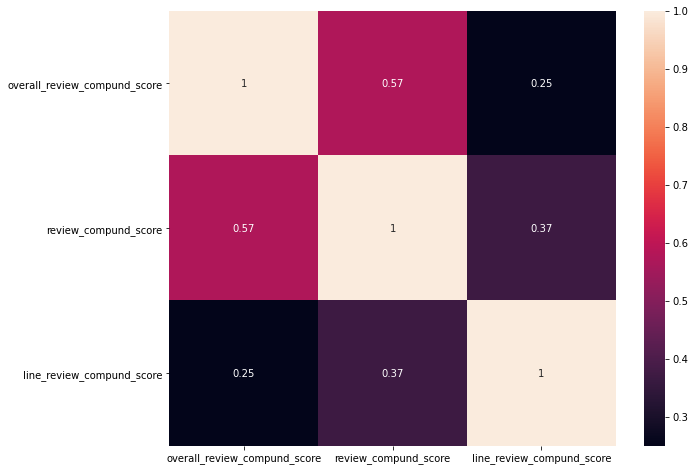

In [57]:
plt.figure(figsize=(10, 8))

sns.heatmap(df_processed_final_data.corr(), annot = True)

# Reading new data with routes, features data filled

In [58]:
df_processed_final_data.head(15)

airline_name Overall_Rating         review_date Verified  \
0   Delta Air Lines              9  11th November 2019     True   
1   Delta Air Lines              9  11th November 2019     True   
2   Delta Air Lines              9  11th November 2019     True   
3   Delta Air Lines              9  11th November 2019     True   
4   Delta Air Lines              9  11th November 2019     True   
5   Delta Air Lines              9  11th November 2019     True   
6   Delta Air Lines              9  11th November 2019     True   
7   Delta Air Lines              9  11th November 2019     True   
8   Delta Air Lines              9  11th November 2019     True   
9   Delta Air Lines              9  11th November 2019     True   
10  Delta Air Lines              9  11th November 2019     True   
11  Delta Air Lines              9  11th November 2019     True   
12  Delta Air Lines              1      25th June 2019     True   
13  Delta Air Lines              1      25th June 2019     True   
14  Delta Air Lines              1      25th June 2019     True   

             Overall_review  \
0   "pretty decent airline"   
1   "pretty decent airline"   
2   "pretty decent airline"   
3   "pretty decent airline"   
4   "pretty decent airline"   
5   "pretty decent airline"   
6   "pretty decent airline"   
7   "pretty decent airline"   
8   "pretty decent airline"   
9   "pretty decent airline"   
10  "pretty decent airline"   
11  "pretty decent airline"   
12     "Not a good airline"   
13     "Not a good airline"   
14     "Not a good airline"   

                                               review  \
0    moroni to moheli. turned out to be pretty dec...   
1    moroni to moheli. turned out to be pretty dec...   
2    moroni to moheli. turned out to be pretty dec...   
3    moroni to moheli. turned out to be pretty dec...   
4    moroni to moheli. turned out to be pretty dec...   
5    moroni to moheli. turned out to be pretty dec...   
6    moroni to moheli. turned out to be pretty dec...   
7    moroni to moheli. turned out to be pretty dec...   
8    moroni to moheli. turned out to be pretty dec...   
9    moroni to moheli. turned out to be pretty dec...   
10   moroni to moheli. turned out to be pretty dec...   
11   moroni to moheli. turned out to be pretty dec...   
12   moroni to anjouan. it is very small airline. ...   
13   moroni to anjouan. it is very small airline. ...   
14   moroni to anjouan. it is very small airline. ...   

                                          line_review              Route  \
0                                    moroni to moheli   Moroni to Moheli   
1              turned out to be pretty decent airline   Moroni to Moheli   
2    online booking worked well checkin and boardi...   Moroni to Moheli   
3    its very short flight just 20 minutes or so s...   Moroni to Moheli   
4                                both flights on time   Moroni to Moheli   
5                                                       Moroni to Moheli   
6                                                       Moroni to Moheli   
7                                                       Moroni to Moheli   
8                                                       Moroni to Moheli   
9                                                       Moroni to Moheli   
10                                                      Moroni to Moheli   
11                                                      Moroni to Moheli   
12                                  moroni to anjouan  Moroni to Anjouan   
13                           it is very small airline  Moroni to Anjouan   
14   my ticket advised me to turn up at 0800hrs wh...  Moroni to Anjouan   

    date_flown seat_comfort cabin_staff_service food entertainment  \
0   11-01-2019            4                   5    4             2   
1   11-01-2019            4                   5    4             2   
2   11-01-2019            4                   5    4             2   
3   11-01-2019            4

In [59]:
df_model = df_processed_final_data[df_processed_final_data['line_review']!=' ']

In [60]:
df_model = df_model.drop(['review_date','Overall_review','review','line_review','Route'],axis=1)


In [61]:
airlines_name = pd.get_dummies(df_model['airline_name'],drop_first=True)
verified = pd.get_dummies(df_model['Verified'],drop_first=True)
recommended = pd.get_dummies(df_model['Recommended'],drop_first=True)
df_model=pd.concat([df_model,airlines_name,verified,recommended],axis=1)
df_model.head(2)

airline_name Overall_Rating Verified  date_flown seat_comfort  \
0  Delta Air Lines              9     True  11-01-2019            4   
1  Delta Air Lines              9     True  11-01-2019            4   

  cabin_staff_service food entertainment Recommended  \
0                   5    4             2         yes   
1                   5    4             2         yes   

   overall_review_compund_score  review_compund_score  \
0                        0.4939                0.9192   
1                        0.4939                0.9192   

  overall_review_sentiments review_sentiments  line_review_compund_score  \
0                  Positive          Positive                     0.0000   
1                  Positive          Positive                     0.4939   

  line_review_sentiments  Delta Air Lines  United Airlines  True  yes  
0                Neutral                1                0     1    1  
1               Positive                1                0     1    1

In [62]:
df_model_final = df_model.drop(['airline_name','Verified','Recommended'],axis=1)
df_model_final = df_model_final.rename(columns={True:"Verified","yes":"recommended"})

In [63]:
df_model_final.head(2)

Overall_Rating  date_flown seat_comfort cabin_staff_service food  \
0              9  11-01-2019            4                   5    4   
1              9  11-01-2019            4                   5    4   

  entertainment  overall_review_compund_score  review_compund_score  \
0             2                        0.4939                0.9192   
1             2                        0.4939                0.9192   

  overall_review_sentiments review_sentiments  line_review_compund_score  \
0                  Positive          Positive                     0.0000   
1                  Positive          Positive                     0.4939   

  line_review_sentiments  Delta Air Lines  United Airlines  Verified  \
0                Neutral                1                0         1   
1               Positive                1                0         1   

   recommended  
0            1  
1            1

In [64]:
df_model_final.Overall_Rating.unique()

array(['9', '1', '8', '2', '3', '5', '6', '7', '4', 'n'], dtype=object)

In [65]:
#df_model_final['Overall_Rating'] = if df_final_model['Overall_Rating']=='n' and df_final_model['overall_review_sentiments']=='Positive'
import random
df_model_final.loc[(df_model_final['Overall_Rating'] == 'n') & (df_model_final['overall_review_sentiments'] == 'Positive'), 'Overall_Rating'] = str(random.randint(8,9))
df_model_final.loc[(df_model_final['Overall_Rating'] == 'n') & (df_model_final['overall_review_sentiments'] == 'Negative'), 'Overall_Rating'] = str(random.randint(1,4))
df_model_final.loc[(df_model_final['Overall_Rating'] == 'n') & (df_model_final['overall_review_sentiments'] == 'Neutral'), 'Overall_Rating'] = str(random.randint(5,7))


In [66]:
df_model_final['Overall_Rating'] = df_model_final['Overall_Rating'].astype('int')
df_model_final['date_flown'] = df_model_final['date_flown'].astype('category')
df_model_final['seat_comfort'] = df_model_final['seat_comfort'].astype('int')
df_model_final['cabin_staff_service'] = df_model_final['cabin_staff_service'].astype('int')
df_model_final['food'] = df_model_final['food'].astype('int')
df_model_final['entertainment'] = df_model_final['entertainment'].astype('int')
df_model_final['overall_review_sentiments'] = df_model_final['overall_review_sentiments'].astype('category')
df_model_final['review_sentiments'] = df_model_final['review_sentiments'].astype('category')
df_model_final['line_review_sentiments'] = df_model_final['line_review_sentiments'].astype('category')


In [67]:
df_model_final.columns

Index(['Overall_Rating', 'date_flown', 'seat_comfort', 'cabin_staff_service',
       'food', 'entertainment', 'overall_review_compund_score',
       'review_compund_score', 'overall_review_sentiments',
       'review_sentiments', 'line_review_compund_score',
       'line_review_sentiments', 'Delta Air Lines', 'United Airlines',
       'Verified', 'recommended'],
      dtype='object')

In [68]:
test = df_processed_final_data[df_processed_final_data['line_review']!=' ']
test.to_csv('final_data_with_Sentiments_BDA.csv',index=None)

# Building Random Forest to predict overall sentiments 

In [69]:
X = df_model_final.drop(['review_compund_score','date_flown','overall_review_sentiments','review_sentiments', 'line_review_compund_score','line_review_sentiments','Delta Air Lines', 'United Airlines'],axis=1)
y = df_model_final['overall_review_sentiments']

classes = list(y.cat.categories)
#print(y)
print(classes)

['Negative', 'Neutral', 'Positive']


In [70]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=42)

In [71]:
#X_test.to_csv('test1.csv',index=None)

In [72]:
#random_model = RandomForestClassifier(n_estimators=5, random_state=42,min_samples_split=4)
#random_model.fit(X_train, y_train)

#y_pred = random_model.predict(X_test)

In [73]:
#feature_importances = random_model.feature_importances_
#print('Feature Importances:')
#for feature, importance in zip(X_train, feature_importances):
#    print(f'{feature}: {importance:.4f}')

In [74]:
#accuracy = accuracy_score(y_test, y_pred)
#print(f'Accuracy: {accuracy:.2f}')

# Generate a classification report
#print(classification_report(y_test, y_pred))

# Create a confusion matrix
#conf_matrix = confusion_matrix(y_test, y_pred)
#print('Confusion Matrix:')
#print(conf_matrix)

In [75]:
#y_pred_train = random_model.predict(X_train)

In [76]:
#accuracy = accuracy_score(y_train, y_pred_train)
#print(f'Accuracy: {accuracy:.2f}')

# Generate a classification report
#print(classification_report(y_train, y_pred_train))

# Create a confusion matrix
#conf_matrix = confusion_matrix(y_train, y_pred_train)
#print('Confusion Matrix:')
#print(conf_matrix)

In [77]:
#from dmba import classificationSummary
#classificationSummary(y_train, y_pred_train, class_names=classes)

#print()

#classificationSummary(y_test,y_pred, class_names=classes)

# New Method using word clouds

In [78]:
df_processed_final_data.head(1)

airline_name Overall_Rating         review_date Verified  \
0  Delta Air Lines              9  11th November 2019     True   

            Overall_review                                             review  \
0  "pretty decent airline"   moroni to moheli. turned out to be pretty dec...   

         line_review             Route  date_flown seat_comfort  \
0   moroni to moheli  Moroni to Moheli  11-01-2019            4   

  cabin_staff_service food entertainment Recommended  \
0                   5    4             2         yes   

   overall_review_compund_score  review_compund_score  \
0                        0.4939                0.9192   

  overall_review_sentiments review_sentiments  line_review_compund_score  \
0                  Positive          Positive                        0.0   

  line_review_sentiments  
0                Neutral

In [79]:
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import LancasterStemmer
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [80]:
df_new = df_processed_final_data[['airline_name','Overall_review','review','overall_review_sentiments','review_sentiments']]

In [81]:
df_new.shape

(278052, 5)

In [82]:
df_new = df_new.drop_duplicates()

<AxesSubplot:xlabel='review_sentiments', ylabel='count'>

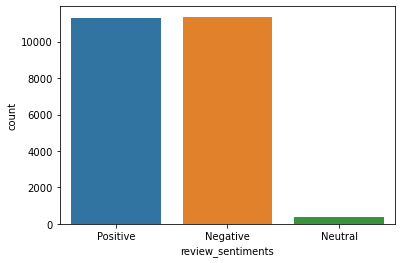

In [83]:
sns.countplot(x=df_new['review_sentiments'])

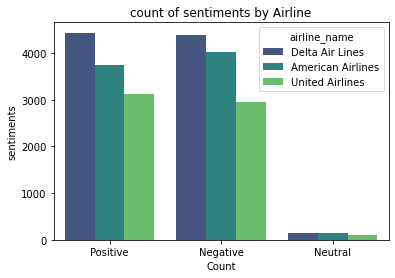

In [84]:
combined = sns.countplot(x='review_sentiments',data=df_new,hue='airline_name', palette='viridis')
combined.set_xlabel('Count')
combined.set_ylabel('sentiments')
combined.set_title("count of sentiments by Airline")

plt.show()

In [85]:
fillers_to_remove = list(stopwords.words('english'))+list(punctuation)
stemmer = LancasterStemmer()
corpus = df_new['review'].tolist()
print(len(corpus))
print(corpus[0])

23049
 moroni to moheli. turned out to be pretty decent airline. online booking worked well checkin and boarding was fine and the plane looked well maintained. its very short flight just 20 minutes or so so didn expect much but they still managed to hand our bottle of water and some biscuits which though was very nice. both flights on time.


In [86]:
final_corpus = []
final_corpus_joined = []
for i in df_new.index:
    text = df_new['review'][i]
    text = text.split()
    lem = SnowballStemmer("english")
    text = [lem.stem(word) for word in text if not word in fillers_to_remove] 
    text1 = " ".join(text)
    final_corpus.append(text)
    final_corpus_joined.append(text1)

In [87]:
print(final_corpus_joined[0])


moroni moheli. turn pretti decent airline. onlin book work well checkin board fine plane look well maintained. short flight 20 minut expect much still manag hand bottl water biscuit though nice. flight time.


In [99]:
cleaned_data = pd.DataFrame()
cleaned_data["reviews"] = final_corpus_joined
cleaned_data["sentiment"] = df_new["review_sentiments"].values

In [100]:
cleaned_data.head()

reviews sentiment
0  moroni moheli. turn pretti decent airline. onl...  Positive
1  moroni anjouan. small airline. ticket advis tu...  Negative
2  anjouan dzaoudzi. small airlin airlin base com...  Positive
3  pleas favor fli adria. rout munich pristina ju...  Negative
4  book flight airlin friend return sofia amsterd...  Positive

In [101]:
#data for wordcloud
eda_analysis = pd.DataFrame()
eda_analysis['reviews'] = final_corpus
eda_analysis['sentiment'] = df_new['review_sentiments'].values
eda_analysis.head()

reviews sentiment
0  [moroni, moheli., turn, pretti, decent, airlin...  Positive
1  [moroni, anjouan., small, airline., ticket, ad...  Negative
2  [anjouan, dzaoudzi., small, airlin, airlin, ba...  Positive
3  [pleas, favor, fli, adria., rout, munich, pris...  Negative
4  [book, flight, airlin, friend, return, sofia, ...  Positive

In [91]:
positive = eda_analysis[eda_analysis['sentiment'] == 'Positive']
positive_list = positive['reviews'].tolist()
negative = eda_analysis[eda_analysis['sentiment'] == 'Negative']
negative_list = negative['reviews'].tolist()

In [92]:
positive_all = " ".join([word for sent in positive_list for word in sent ])
negative_all = " ".join([word for sent in negative_list for word in sent ])

In [93]:
positive_all

'moroni moheli. turn pretti decent airline. onlin book work well checkin board fine plane look well maintained. short flight 20 minut expect much still manag hand bottl water biscuit though nice. flight time. anjouan dzaoudzi. small airlin airlin base comoros. check disorganis local big packag disinterest staff. flight fortun short 30 min took time land time. short flight like cours flight entertain cabin servic except biscuit bottl water quit nice book flight airlin friend return sofia amsterdam septemb 22 3 day sent us sms inform flight cancelled. 3 straight day tri reach airlin web agent dream get solution. final 18 hour cancel flight time 35 minut call wait airlin abl get us flight lufthansa. book delta air line unreli case ruin last day holiday sinc need phone day. ljubljana munich. homebas airport delta air line ljubljana small relax convenient. surround alp departur fantastic. airplan modern crew nice. ontim departure. drink without alcohol free paid 4 white wine. consid cheap t

In [94]:
pip install WordCloud

Note: you may need to restart the kernel to use updated packages.


In [95]:
pip install pillow version <=9.5.0

Note: you may need to restart the kernel to use updated packages.


The system cannot find the file specified.


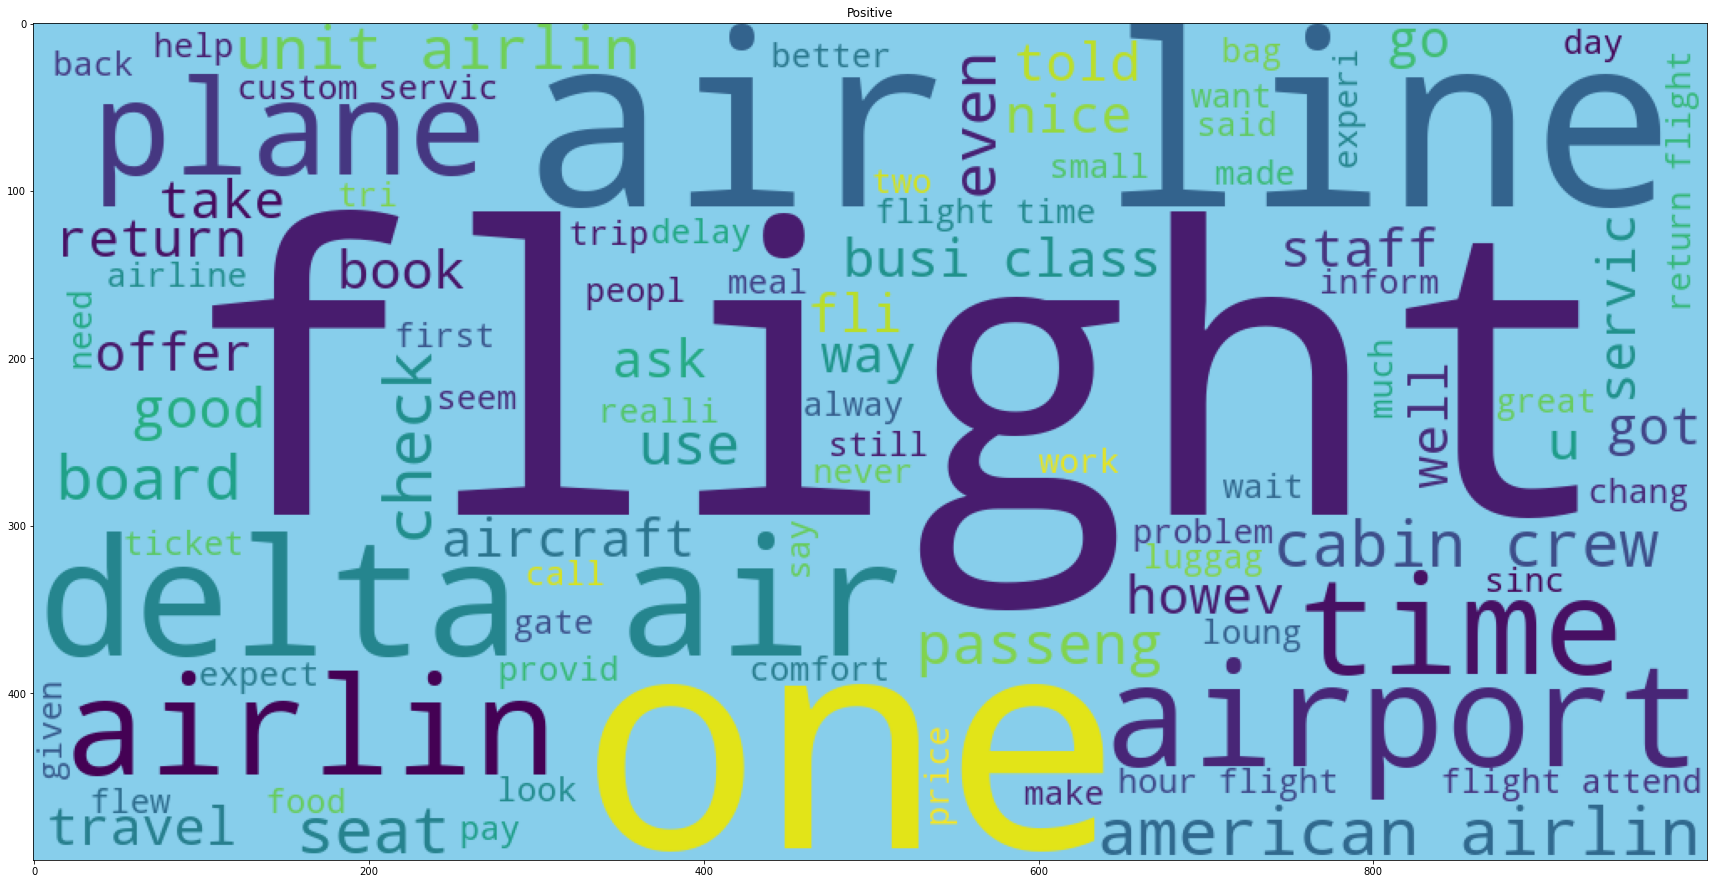

In [96]:
from wordcloud import WordCloud
WordCloud()
wordcloud = WordCloud(width=1000,height=500,background_color='skyblue',max_words = 90).generate(positive_all)

plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.title("Positive")
plt.show()

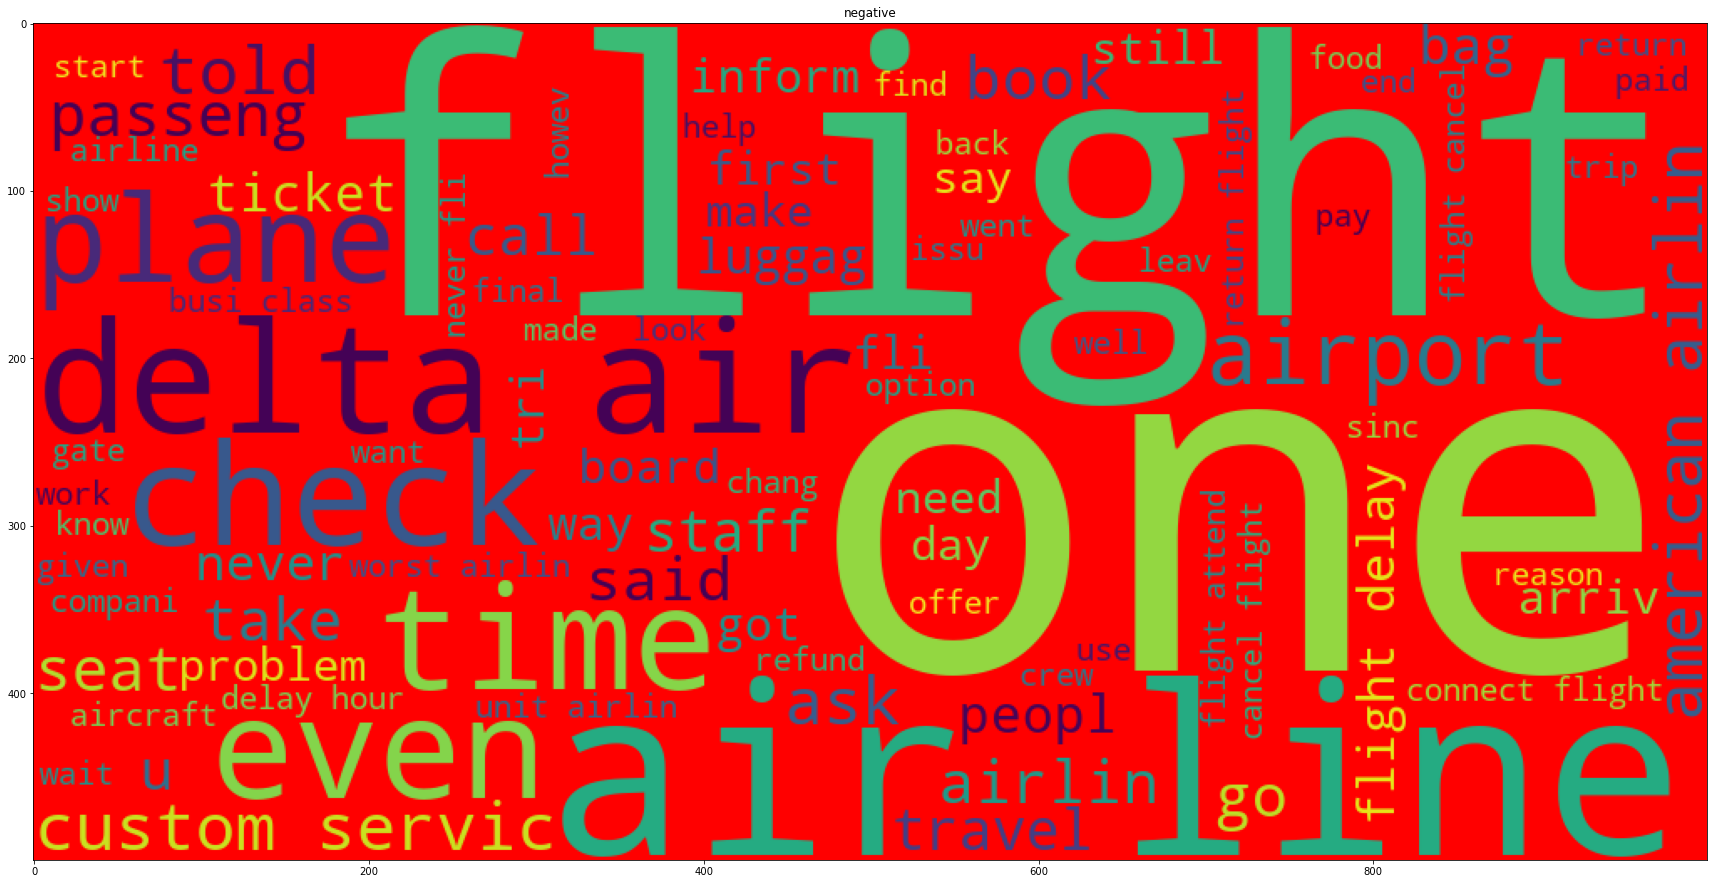

In [98]:
from wordcloud import WordCloud
WordCloud()
wordcloud = WordCloud(width=1000,height=500,background_color='red',max_words = 90).generate(negative_all)

plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.title("negative")
plt.show()

# Displaying charts with one word about Positive and Negative reviews

In [227]:
def get_word_counts(data):
    dic = {}
    for i in data:
        for j in i:
            if j not in dic:
                dic[j]=1
            else:
                dic[j]+=1    
            
    return(dic)
positive_count_corpus = get_word_counts(positive_list)
negative_count_corpus = get_word_counts(negative_list)

In [221]:
positive_words_data = pd.DataFrame({"word":positive_count_corpus.keys(),"counts":positive_count_corpus.values()})
positive_words_data = positive_words_data.sort_values(by = "counts", ascending = False)

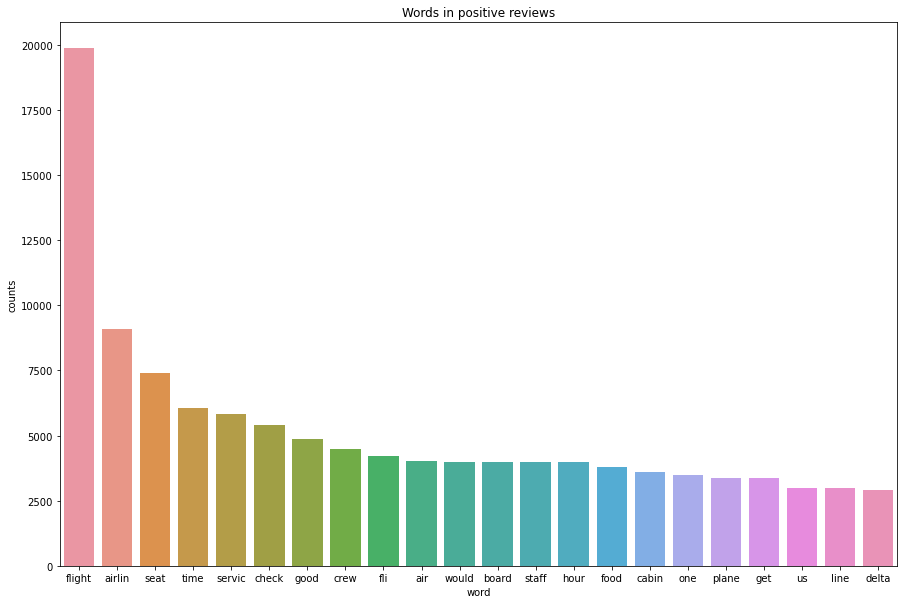

In [222]:
import seaborn as sns
plt.figure(figsize = (15,10))
sns.barplot(x = positive_words_data["word"][:22], y = positive_words_data["counts"][:22])
plt.title('Words in positive reviews')
plt.show()

In [228]:
negative_words_data = pd.DataFrame({"word":negative_count_corpus.keys(),"counts":negative_count_corpus.values()})
negative_words_data = negative_words_data.sort_values(by = "counts", ascending = False)

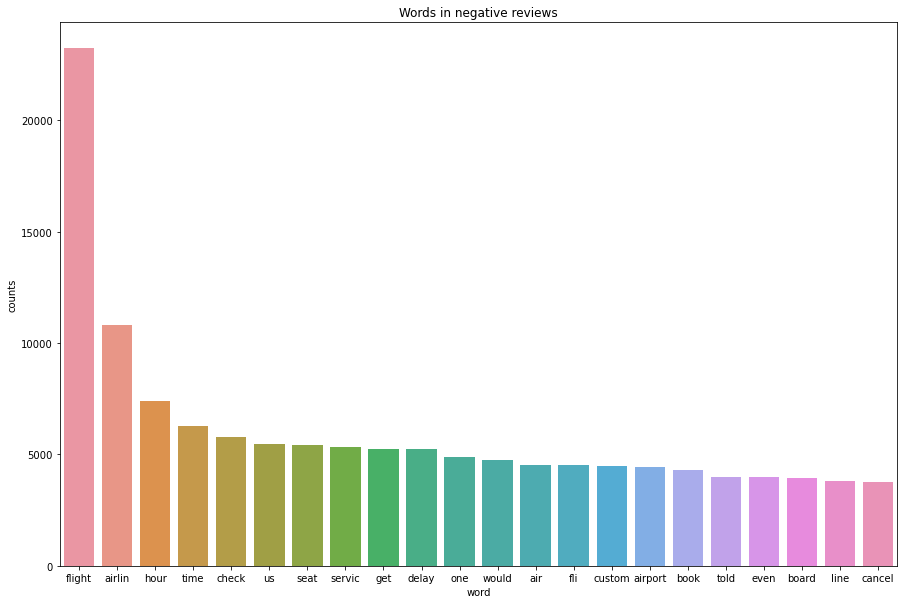

In [229]:
import seaborn as sns
plt.figure(figsize = (15,10))
sns.barplot(x = negative_words_data["word"][:22], y = negative_words_data["counts"][:22])
plt.title('Words in negative reviews')
plt.show()

# Prediction Models

In [127]:
X = cleaned_data['reviews']
y = cleaned_data['sentiment'].astype('category')

In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer()
Xt = tfid.fit_transform(X)

# Logistic Regression

In [129]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.4, random_state= 100)
classes = list(y.cat.categories)
#print(y)
print(classes)

['Negative', 'Neutral', 'Positive']


In [209]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l2', C=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train= model.predict(X_train)

C:\Users\Dhoot\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


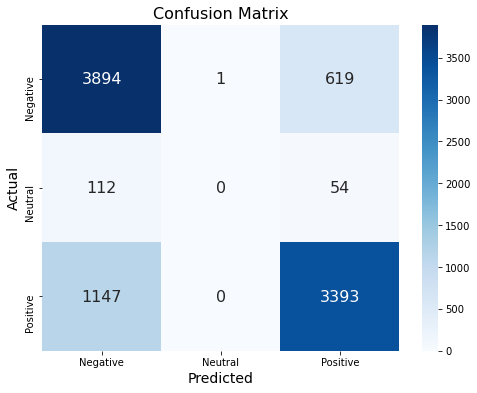

Accuracy on test data is: 0.85


In [210]:
# Performance of Logistic model
cm = confusion_matrix(y_test, y_valid_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test data is: {accuracy:.2f}')



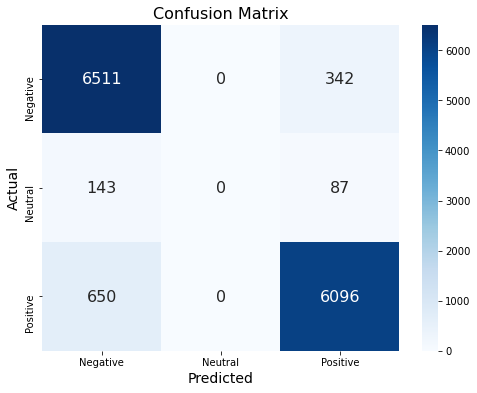

Accuracy on test data is: 0.86


In [212]:
# preformance of logistic model

cm = confusion_matrix(y_train, y_pred_train)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

accuracy = accuracy_score(y_train, y_pred_train)
print(f'Accuracy on test data is: {accuracy:.2f}')

# Random Forest

In [206]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)
y_pred_train = random_forest_model.predict(X_train)

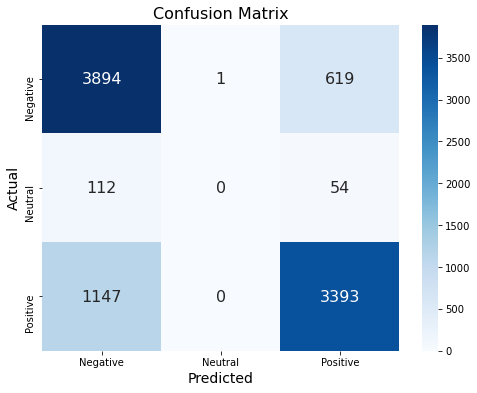

Accuracy on test data is: 0.81


In [207]:
# Performance of random forest model
cm = confusion_matrix(y_test, y_valid_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test data is: {accuracy:.2f}')


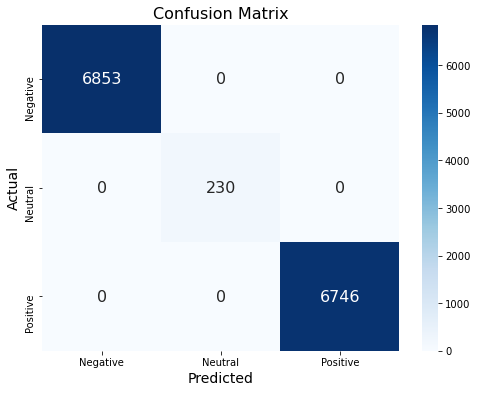

Accuracy on test data is: 1.00


In [208]:
# Performance of random forest model
cm = confusion_matrix(y_train, y_pred_train)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

accuracy = accuracy_score(y_train, y_pred_train)
print(f'Accuracy on test data is: {accuracy:.2f}')

# Naive Bayes

In [174]:
from sklearn.naive_bayes import MultinomialNB

In [186]:
# run naive Bayes
naive_model = MultinomialNB(alpha=1)
naive_model.fit(X_train, y_train)

# predict probabilities
predProb_train = naive_model.predict_proba(X_train)
predProb_valid = naive_model.predict_proba(X_test)

# predict class membership
y_valid_pred = naive_model.predict(X_test)
y_train_pred = naive_model.predict(X_train)

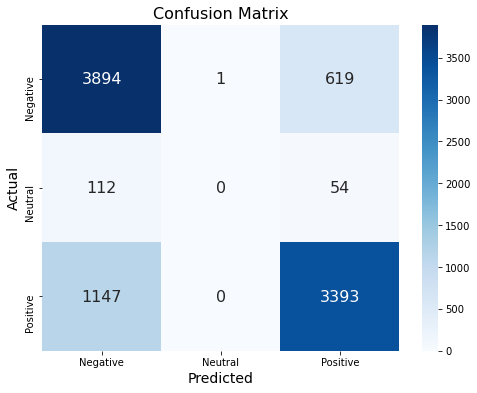

Accuracy on test data is: 0.821


In [204]:
cm = confusion_matrix(y_test, y_valid_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

accuracy = accuracy_score(y_test, y_valid_pred)
print(f'Accuracy on test data is: {accuracy:.3f}')

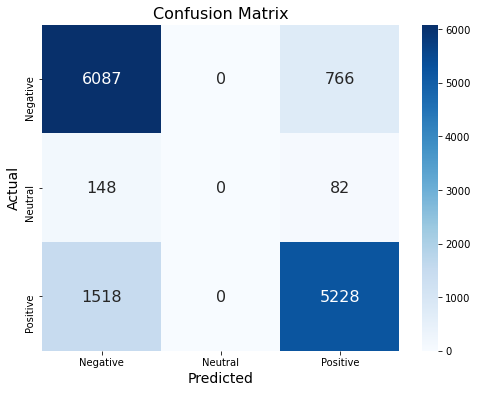

Accuracy on train data is: 0.82


In [201]:
cm = confusion_matrix(y_train, y_train_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()


accuracy = accuracy_score(y_train, y_train_pred)
print(f'Accuracy on train data is: {accuracy:.2f}')